In [10]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt 

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("spark")\
    .config('spark.driver.memory', '32g')\
    .config("hive.server2.thrift.port", 10000)\
    .config("spark.sql.hive.thriftServer.singleSession", True)\
    .enableHiveSupport()\
    .getOrCreate()

spc = SparkSession.sparkContext

In [51]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType,TimestampType
from pyspark.sql.types import DateType
from pyspark.sql.functions import *

schema = StructType([
    StructField("ID", IntegerType()),
    StructField("Speed", DoubleType()),
    StructField("TravelTime", IntegerType()),
    StructField("Status", IntegerType()),
    StructField("timedate", StringType()),
    StructField("LinkId", IntegerType()),
    StructField("LinkPoints", StringType()),
    StructField("EncodedLinkPoints", StringType()),
    StructField("EncodedPolyLineLvls", StringType()),
    StructField("Owner", StringType()),
    StructField("TranscomId", IntegerType()),
    StructField("Borough", StringType()),
    StructField("Link_Name", StringType())
])

schema1 = "ID bigint, Speed float, TravelTime int, Status int, TimeDate string, LinkId int, LinkPoints string, EncodedLinkPoints string, EncodedPolyLineLvls string, Owner string, TranscomId int, Borough string,Link_Name string"
df2 = spark.read.format("csv").option("header", "true").schema(schema1).load("file:/Users/minoseah629/Downloads/DOT_Traffic_Speeds_NBE.csv")
df2 = df2.withColumn("timedate", to_timestamp("timedate", 'MM/dd/yyyy hh:mm:ss a'))
df2 = df2.na.drop()
df2 = df2.drop(*("Status","EncodedLinkPoints","EncodedPolyLineLvls","TranscomId"))
df2.printSchema()
df2.createOrReplaceTempView("dataset")

# boston = load_boston()
# print(boston.feature_names)
# df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
# df_boston['target'] = pd.Series(boston.target)
# print(df_boston.head())

root
 |-- ID: long (nullable = true)
 |-- Speed: float (nullable = true)
 |-- TravelTime: integer (nullable = true)
 |-- timedate: timestamp (nullable = true)
 |-- LinkId: integer (nullable = true)
 |-- LinkPoints: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Link_Name: string (nullable = true)



In [52]:
df_boston= df2.to_pandas_on_spark()

In [54]:
sqlContext = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
# schema1 = "ID string, Speed string, TravelTime string, TimeDate string, LinkId string, LinkPoints string, Owner string, Borough string,Link_Name string"
# df_boston = df_boston.drop(columns=("ID"))
data = sqlContext.createDataFrame(df_boston, schema=schema1)
print(data.printSchema()) 

TypeError: StructType can not accept object 'ID' in type <class 'str'>

In [9]:
features = boston.feature_names.tolist()

va = VectorAssembler(inputCols=features, outputCol='features')
print(va)
va_df = va.transform(data)
print(va_df)
va_df = va_df.select(['features', 'target'])
print(va_df)
va_df.show(3)

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

VectorAssembler_56866d67fe47
DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: double, NOX: double, RM: double, AGE: double, DIS: double, RAD: double, TAX: double, PTRATIO: double, B: double, LSTAT: double, target: double, features: vector]
DataFrame[features: vector, target: double]
+--------------------+------+
|            features|target|
+--------------------+------+
|[0.00632,18.0,2.3...|  24.0|
|[0.02731,0.0,7.07...|  21.6|
|[0.02729,0.0,7.07...|  34.7|
+--------------------+------+
only showing top 3 rows



In [5]:
(train, test) = va_df.randomSplit([0.8, 0.2])

In [6]:
glr=GeneralizedLinearRegression(labelCol="target",family="poisson",maxIter=10,regParam=0.3)

model = glr.fit(train)
 
print("Coefficients: ", model.coefficients)
print("Intercept: ", model.intercept)
 


22/03/24 23:09:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/24 23:09:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/03/24 23:09:40 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients:  [-0.009927249072224286,0.0016275302585009596,-0.0006742292224727747,0.022832434643081125,-0.007189265687798964,0.0640299739649949,0.0003820766872218509,-0.040373027207059174,0.013781743253364193,-0.000630183015123388,-0.03268809311348797,0.0004826954632922484,-0.03552206292403898]
Intercept:  3.8089315913878345


In [7]:
print(model.summary)

Coefficients:
    Feature Estimate Std Error  T Value P Value
(Intercept)   3.8089    0.1725  22.0770  0.0000
       CRIM  -0.0099    0.0022  -4.4768  0.0000
         ZN   0.0016    0.0006   2.7077  0.0068
      INDUS  -0.0007    0.0029  -0.2350  0.8142
       CHAS   0.0228    0.0171   1.3383  0.1808
        NOX  -0.0072    0.0190  -0.3788  0.7048
         RM   0.0640    0.0138   4.6402  0.0000
        AGE   0.0004    0.0006   0.6313  0.5278
        DIS  -0.0404    0.0084  -4.7988  0.0000
        RAD   0.0138    0.0035   3.9348  0.0001
        TAX  -0.0006    0.0002  -3.1567  0.0016
    PTRATIO  -0.0327    0.0057  -5.7813  0.0000
          B   0.0005    0.0002   3.0917  0.0020
      LSTAT  -0.0355    0.0025 -14.3560  0.0000

(Dispersion parameter for poisson family taken to be 1.0000)
   Null deviance: 1432.7378 on 398 degrees of freedom
Residual deviance: 306.9978 on 398 degrees of freedom
AIC: 2343.8703


In [8]:
tdata = model.transform(test)
tdata.show(3)

rmse = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(tdata)
mae = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(tdata)
r2 = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(tdata)

+--------------------+------+------------------+
|            features|target|        prediction|
+--------------------+------+------------------+
|[0.03237,0.0,2.18...|  33.4| 29.99131237895127|
|[0.03359,75.0,2.9...|  34.9|  35.4562242082854|
|[0.06905,0.0,2.18...|  36.2|27.924139211480725|
+--------------------+------+------------------+
only showing top 3 rows



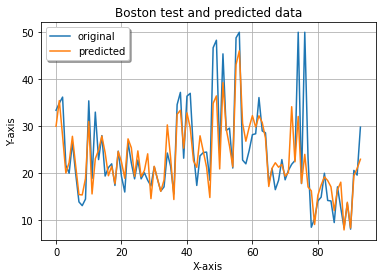

In [9]:
x_ax = range(0, tdata.count())
y_pred=tdata.select("prediction").collect()
y_orig=tdata.select("target").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [3]:
sc.stop()